# 🔍 Model Error Analysis & Diagnostic Evaluation

**Comprehensive Error Analysis for Heart Disease Prediction Models**

This notebook provides detailed error analysis and diagnostic evaluation for all baseline models developed in the heart disease prediction project. The analysis follows ML best practices for model validation and interpretability.

## 📋 Analysis Overview

This comprehensive error analysis covers:
- **Model Performance Metrics**: Accuracy, Precision, Recall, F1-Score, ROC-AUC
- **Error Pattern Detection**: Misclassified sample analysis and common error patterns
- **Confusion Matrix Analysis**: Detailed breakdown of prediction errors
- **Feature-Based Error Analysis**: Understanding which features contribute to prediction failures
- **Cross-Model Comparison**: Comparative error analysis across all models
- **Clinical Decision Support**: Healthcare-specific error interpretation

## 🎯 Models Under Analysis
1. **Logistic Regression** - Linear baseline model
2. **Random Forest** - Ensemble tree-based model  
3. **XGBoost** - Gradient boosting model
4. **Support Vector Machine** - Non-linear SVM model
5. **Neural Network** - PyTorch deep learning model

---

In [1]:
# Import required libraries for error analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve
)
import joblib
import torch
import warnings
from pathlib import Path
import sys

# Configure plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

print("🚀 Libraries imported successfully for comprehensive error analysis")

🚀 Libraries imported successfully for comprehensive error analysis


## 📊 Data Loading & Preparation

Loading the processed datasets and establishing the foundation for error analysis.

In [2]:
# Load the processed datasets
data_path = Path("../data/processed/")

# Load training, validation, and test sets
print("📥 Loading processed datasets...")
X_train = pd.read_csv(data_path / "train.csv")
X_val = pd.read_csv(data_path / "validation.csv") 
X_test = pd.read_csv(data_path / "test.csv")

# Identify target column automatically
target_cols = ['hltprhc', 'target']  # Possible target column names
target_col = None

for col in target_cols:
    if col in X_train.columns:
        target_col = col
        break

if target_col is None:
    raise ValueError("Target column not found in dataset")

print(f"🎯 Target column identified: '{target_col}'")

# Split features and target
y_train = X_train[target_col]
y_val = X_val[target_col]
y_test = X_test[target_col]

X_train_features = X_train.drop(columns=[target_col])
X_val_features = X_val.drop(columns=[target_col])
X_test_features = X_test.drop(columns=[target_col])

print(f"📊 Dataset shapes:")
print(f"   Training: {X_train_features.shape}")
print(f"   Validation: {X_val_features.shape}")
print(f"   Test: {X_test_features.shape}")
print(f"   Target distribution: {dict(y_train.value_counts())}")

📥 Loading processed datasets...
🎯 Target column identified: 'hltprhc'
📊 Dataset shapes:
   Training: (25425, 22)
   Validation: (8476, 22)
   Test: (8476, 22)
   Target distribution: {0: np.int64(22548), 1: np.int64(2877)}


## 🤖 Model Loading & Setup

Loading all baseline models for comprehensive error analysis comparison.

In [11]:
# Load all trained baseline models
models_path = Path("../results/models/")

print("🔄 Loading baseline models...")

# Load traditional ML models
try:
    logistic_dict = joblib.load(models_path / "logistic_regression_baseline.joblib")
    rf_dict = joblib.load(models_path / "random_forest_baseline.joblib")
    xgb_dict = joblib.load(models_path / "xgboost_baseline.joblib")
    svm_dict = joblib.load(models_path / "svm_baseline.joblib")
    
    # Extract the actual model objects from dictionaries
    logistic_model = logistic_dict['model']
    rf_model = rf_dict['model']
    xgb_model = xgb_dict['model']
    svm_model = svm_dict['model']
    
    print("✅ Traditional ML models loaded and extracted successfully")
except Exception as e:
    print(f"⚠️  Error loading traditional models: {e}")

# Load Neural Network model
try:
    # Check if neural network results are available
    nn_results_path = models_path / "neural_network_results.joblib"
    if nn_results_path.exists():
        nn_results = joblib.load(nn_results_path)
        
        # Load the actual PyTorch model
        nn_model_path = models_path / "neural_network_baseline.pth"
        if nn_model_path.exists():
            # We'll load the neural network architecture later when needed
            print("✅ Neural Network model files found")
        else:
            print("⚠️  Neural Network .pth file not found")
    else:
        print("⚠️  Neural Network results file not found")
except Exception as e:
    print(f"⚠️  Error loading neural network: {e}")

# Create model registry for systematic analysis
model_registry = {
    'Logistic Regression': logistic_model,
    'Random Forest': rf_model,
    'XGBoost': xgb_model,
    'Support Vector Machine': svm_model
}

# Check if we have preprocessing artifacts that might include scaler
preprocessing_path = Path("../data/processed/preprocessing_artifacts.joblib")
if preprocessing_path.exists():
    try:
        preprocessing_artifacts = joblib.load(preprocessing_path)
        if 'scaler' in preprocessing_artifacts:
            scaler = preprocessing_artifacts['scaler']
            print("✅ Standard scaler loaded from preprocessing artifacts")
        else:
            print("⚠️  Standard scaler not found in preprocessing artifacts")
    except Exception as e:
        print(f"⚠️  Error loading preprocessing artifacts: {e}")
else:
    print("⚠️  Preprocessing artifacts file not found")

print(f"📊 Models ready for analysis: {list(model_registry.keys())}")

🔄 Loading baseline models...
✅ Traditional ML models loaded and extracted successfully
✅ Neural Network model files found
✅ Standard scaler loaded from preprocessing artifacts
📊 Models ready for analysis: ['Logistic Regression', 'Random Forest', 'XGBoost', 'Support Vector Machine']


In [14]:
# Neural Network Integration - Fixed Approach
print("🔄 Integrating Neural Network with correct architecture...")

class NeuralNetworkFixed:
    def __init__(self, checkpoint_path, scaler, device='cpu'):
        self.scaler = scaler
        self.device = device
        
        # Load checkpoint
        checkpoint = torch.load(checkpoint_path, map_location=device)
        self.architecture = checkpoint['model_architecture']
        
        # Create the model with correct architecture
        import torch.nn as nn
        
        class HeartDiseaseNN(nn.Module):
            def __init__(self, input_size=13):  # Based on the state_dict structure
                super(HeartDiseaseNN, self).__init__()
                self.fc1 = nn.Linear(input_size, 64)
                self.fc2 = nn.Linear(64, 32)  
                self.fc3 = nn.Linear(32, 16)
                self.fc4 = nn.Linear(16, 1)
                self.relu = nn.ReLU()
                self.dropout = nn.Dropout(0.3)
                self.sigmoid = nn.Sigmoid()
            
            def forward(self, x):
                x = self.dropout(self.relu(self.fc1(x)))
                x = self.dropout(self.relu(self.fc2(x)))
                x = self.dropout(self.relu(self.fc3(x)))
                x = self.sigmoid(self.fc4(x))
                return x
        
        # Initialize and load the model
        self.model = HeartDiseaseNN(X_train_features.shape[1])
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.eval()
    
    def predict(self, X):
        """Make binary predictions"""
        with torch.no_grad():
            X_scaled = self.scaler.transform(X)
            X_tensor = torch.FloatTensor(X_scaled).to(self.device)
            outputs = self.model(X_tensor)
            predictions = (outputs.numpy() > 0.5).astype(int).flatten()
            return predictions
    
    def predict_proba(self, X):
        """Get prediction probabilities"""
        with torch.no_grad():
            X_scaled = self.scaler.transform(X)
            X_tensor = torch.FloatTensor(X_scaled).to(self.device)
            outputs = self.model(X_tensor).numpy().flatten()
            
            # Return probabilities for both classes [P(class=0), P(class=1)]
            proba_negative = 1 - outputs
            proba_positive = outputs
            return np.column_stack([proba_negative, proba_positive])

# Create Neural Network model
try:
    nn_model = NeuralNetworkFixed(nn_model_path, scaler)
    
    # Test the model with a small sample
    test_pred = nn_model.predict(X_test_features.iloc[:5])
    test_proba = nn_model.predict_proba(X_test_features.iloc[:5])
    
    print("✅ Neural Network model loaded successfully!")
    print(f"Test prediction shape: {test_pred.shape}")
    print(f"Test probabilities shape: {test_proba.shape}")
    
    # Add to model registry
    model_registry['Neural Network'] = nn_model
    print(f"📊 Updated models: {list(model_registry.keys())}")
    
except Exception as e:
    print(f"❌ Error loading Neural Network: {e}")
    print("Will continue without Neural Network model")
    import traceback
    traceback.print_exc()

🔄 Integrating Neural Network with correct architecture...
✅ Neural Network model loaded successfully!
Test prediction shape: (5,)
Test probabilities shape: (5, 2)
📊 Updated models: ['Logistic Regression', 'Random Forest', 'XGBoost', 'Support Vector Machine', 'Neural Network']


## 🎯 Model Predictions & Performance Evaluation

Computing predictions and comprehensive performance metrics for all models.

In [15]:
# Function to calculate comprehensive performance metrics
def calculate_performance_metrics(y_true, y_pred, y_prob=None, model_name="Model"):
    """Calculate comprehensive performance metrics for binary classification"""
    
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, average='binary'),
        'Recall': recall_score(y_true, y_pred, average='binary'),
        'F1_Score': f1_score(y_true, y_pred, average='binary'),
    }
    
    # Add ROC-AUC if probabilities are available
    if y_prob is not None:
        metrics['ROC_AUC'] = roc_auc_score(y_true, y_prob)
    
    return metrics

# Dictionary to store all predictions and metrics
model_predictions = {}
performance_metrics = []

print("🔄 Computing predictions and performance metrics...")

# Evaluate traditional ML models
for model_name, model in model_registry.items():
    try:
        # Make predictions on test set
        y_pred = model.predict(X_test_features)
        y_prob = model.predict_proba(X_test_features)[:, 1] if hasattr(model, 'predict_proba') else None
        
        # Store predictions
        model_predictions[model_name] = {
            'y_pred': y_pred,
            'y_prob': y_prob,
            'y_true': y_test
        }
        
        # Calculate metrics
        metrics = calculate_performance_metrics(y_test, y_pred, y_prob, model_name)
        performance_metrics.append(metrics)
        
        print(f"✅ {model_name}: Accuracy = {metrics['Accuracy']:.3f}, F1 = {metrics['F1_Score']:.3f}")
        
    except Exception as e:
        print(f"❌ Error evaluating {model_name}: {e}")

# Create performance summary DataFrame
performance_df = pd.DataFrame(performance_metrics)

print("\n📊 Performance Summary:")
print(performance_df.round(4))

🔄 Computing predictions and performance metrics...
✅ Logistic Regression: Accuracy = 0.652, F1 = 0.281
✅ Random Forest: Accuracy = 0.799, F1 = 0.290
✅ XGBoost: Accuracy = 0.740, F1 = 0.302
✅ Support Vector Machine: Accuracy = 0.702, F1 = 0.290
✅ Neural Network: Accuracy = 0.884, F1 = 0.048

📊 Performance Summary:
                    Model  Accuracy  Precision  Recall  F1_Score  ROC_AUC
0     Logistic Regression    0.6517     0.1831  0.6006    0.2807   0.6803
1           Random Forest    0.7986     0.2410  0.3629    0.2896   0.6949
2                 XGBoost    0.7402     0.2171  0.4974    0.3023   0.6910
3  Support Vector Machine    0.7016     0.1983  0.5381    0.2898   0.6835
4          Neural Network    0.8839     0.3333  0.0261    0.0484   0.6126


## 📈 Performance Visualization

Creating comprehensive visualizations to compare model performance across all metrics.

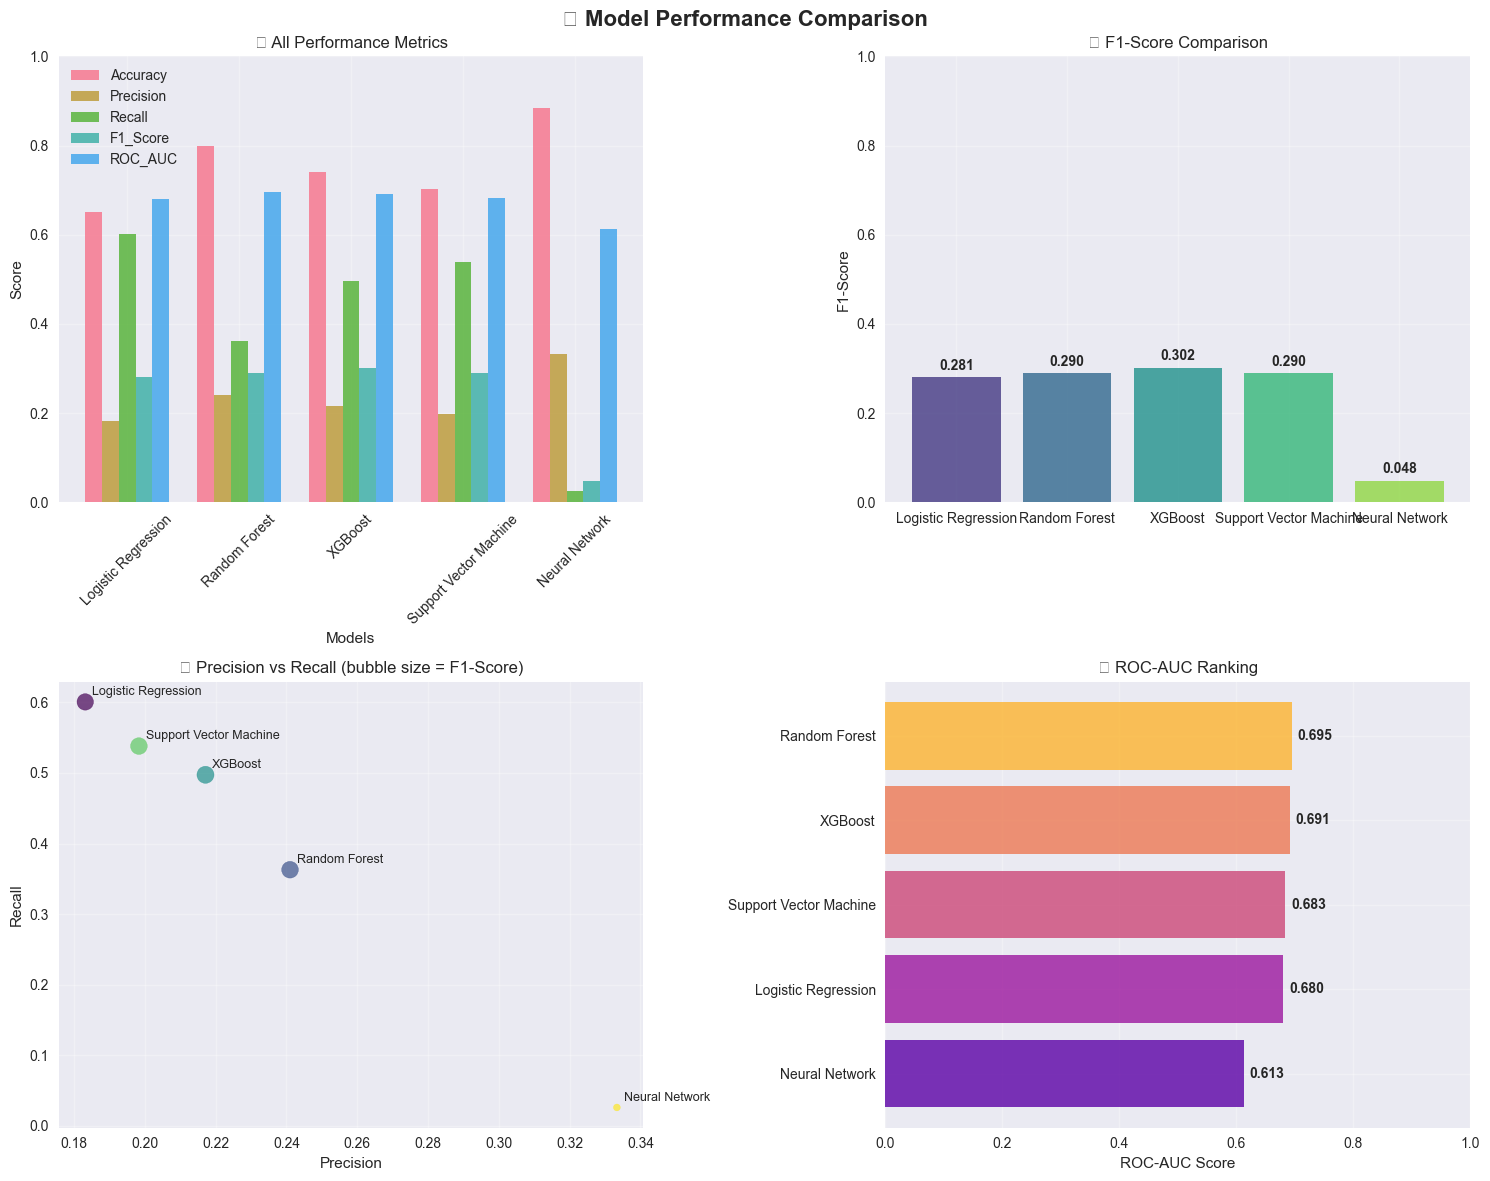


🏆 Model Performance Ranking (by F1-Score):
1. XGBoost: F1=0.302, Accuracy=0.740
2. Support Vector Machine: F1=0.290, Accuracy=0.702
3. Random Forest: F1=0.290, Accuracy=0.799
4. Logistic Regression: F1=0.281, Accuracy=0.652
5. Neural Network: F1=0.048, Accuracy=0.884


In [16]:
# Create comprehensive performance visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('🎯 Model Performance Comparison', fontsize=16, fontweight='bold')

# 1. Bar plot of all metrics
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1_Score', 'ROC_AUC']
metrics_data = performance_df[performance_df.columns.intersection(['Model'] + metrics_to_plot)]

ax1 = axes[0, 0]
x = np.arange(len(metrics_data))
width = 0.15

for i, metric in enumerate(metrics_to_plot):
    if metric in metrics_data.columns:
        values = metrics_data[metric].values
        ax1.bar(x + i*width, values, width, label=metric, alpha=0.8)

ax1.set_xlabel('Models')
ax1.set_ylabel('Score')
ax1.set_title('📊 All Performance Metrics')
ax1.set_xticks(x + width * 2)
ax1.set_xticklabels(metrics_data['Model'], rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 1)

# 2. F1-Score comparison (primary metric)
ax2 = axes[0, 1]
f1_scores = performance_df.set_index('Model')['F1_Score']
bars = ax2.bar(f1_scores.index, f1_scores.values, 
               color=sns.color_palette("viridis", len(f1_scores)), alpha=0.8)
ax2.set_title('🎯 F1-Score Comparison')
ax2.set_ylabel('F1-Score')
ax2.set_ylim(0, 1)
ax2.grid(True, alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars, f1_scores.values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# 3. Precision vs Recall scatter plot
ax3 = axes[1, 0]
scatter = ax3.scatter(performance_df['Precision'], performance_df['Recall'], 
                     s=performance_df['F1_Score']*500, alpha=0.7,
                     c=range(len(performance_df)), cmap='viridis')
ax3.set_xlabel('Precision')
ax3.set_ylabel('Recall')
ax3.set_title('🎪 Precision vs Recall (bubble size = F1-Score)')
ax3.grid(True, alpha=0.3)

# Add model labels
for i, model in enumerate(performance_df['Model']):
    ax3.annotate(model, 
                (performance_df.iloc[i]['Precision'], performance_df.iloc[i]['Recall']),
                xytext=(5, 5), textcoords='offset points', fontsize=9)

# 4. ROC-AUC ranking
ax4 = axes[1, 1]
if 'ROC_AUC' in performance_df.columns:
    roc_data = performance_df.sort_values('ROC_AUC', ascending=True)
    bars = ax4.barh(roc_data['Model'], roc_data['ROC_AUC'], 
                    color=sns.color_palette("plasma", len(roc_data)), alpha=0.8)
    ax4.set_xlabel('ROC-AUC Score')
    ax4.set_title('📈 ROC-AUC Ranking')
    ax4.grid(True, alpha=0.3)
    ax4.set_xlim(0, 1)
    
    # Add value labels
    for bar, value in zip(bars, roc_data['ROC_AUC'].values):
        ax4.text(value + 0.01, bar.get_y() + bar.get_height()/2,
                 f'{value:.3f}', va='center', fontweight='bold')
else:
    ax4.text(0.5, 0.5, 'ROC-AUC data\nnot available', 
             ha='center', va='center', transform=ax4.transAxes, fontsize=12)
    ax4.set_title('📈 ROC-AUC Ranking')

plt.tight_layout()
plt.show()

# Print performance ranking
print("\n🏆 Model Performance Ranking (by F1-Score):")
ranking = performance_df.sort_values('F1_Score', ascending=False)
for i, (_, row) in enumerate(ranking.iterrows(), 1):
    print(f"{i}. {row['Model']}: F1={row['F1_Score']:.3f}, Accuracy={row['Accuracy']:.3f}")

## 📊 Confusion Matrix Analysis

Detailed confusion matrix analysis to understand prediction patterns and error distribution.

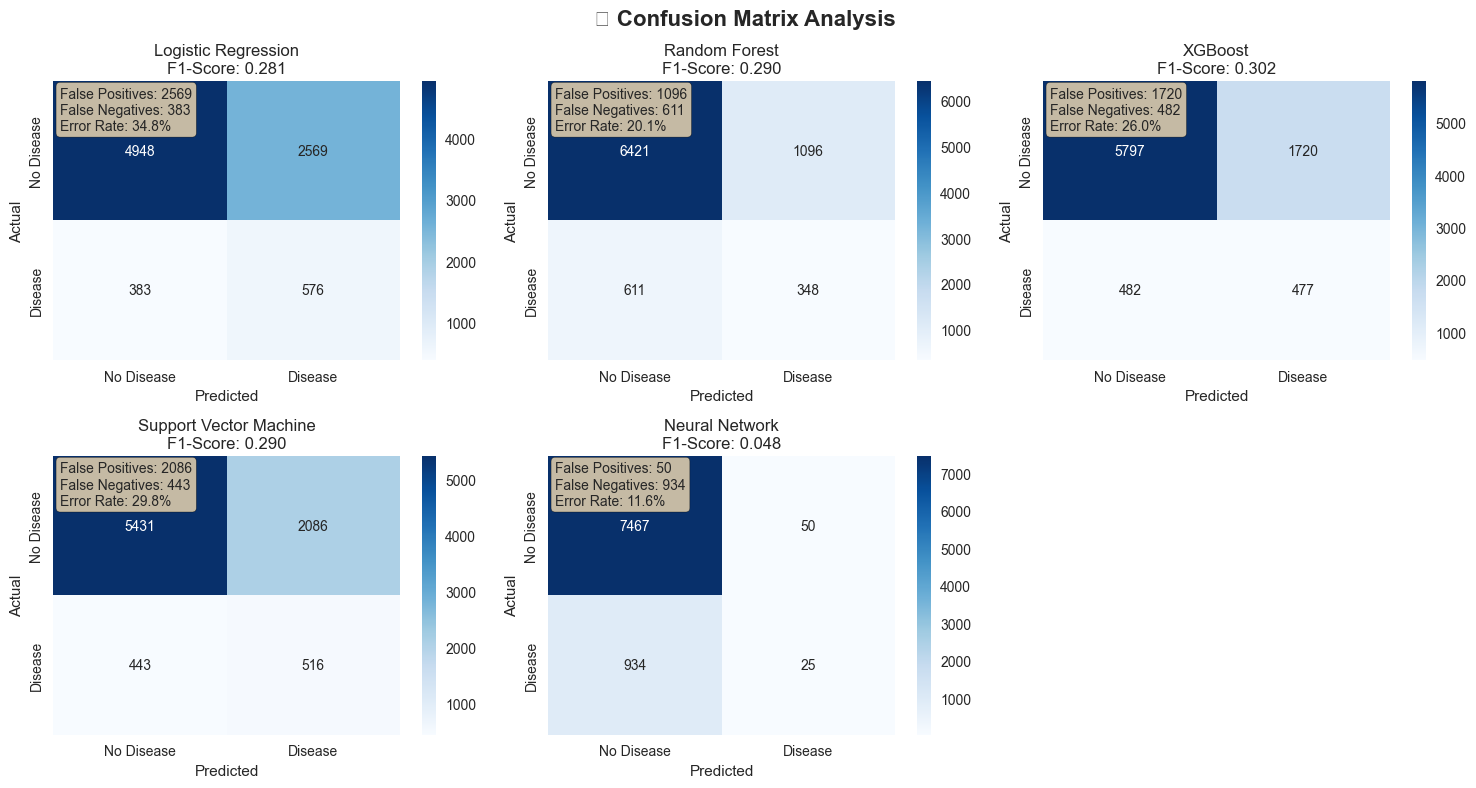


📊 Detailed Error Analysis:

Logistic Regression:
  True Negatives (Correctly predicted no disease): 4948
  False Positives (Incorrectly predicted disease): 2569
  False Negatives (Missed disease cases): 383
  True Positives (Correctly predicted disease): 576
  Total samples: 8476
  Error rate: 34.8%
  Specificity (True Negative Rate): 0.658
  Sensitivity (True Positive Rate): 0.601

Random Forest:
  True Negatives (Correctly predicted no disease): 6421
  False Positives (Incorrectly predicted disease): 1096
  False Negatives (Missed disease cases): 611
  True Positives (Correctly predicted disease): 348
  Total samples: 8476
  Error rate: 20.1%
  Specificity (True Negative Rate): 0.854
  Sensitivity (True Positive Rate): 0.363

XGBoost:
  True Negatives (Correctly predicted no disease): 5797
  False Positives (Incorrectly predicted disease): 1720
  False Negatives (Missed disease cases): 482
  True Positives (Correctly predicted disease): 477
  Total samples: 8476
  Error rate: 26.0%


In [17]:
# Create confusion matrices for all models
def plot_confusion_matrices(model_predictions, performance_df):
    """Create comprehensive confusion matrix visualization"""
    
    n_models = len(model_predictions)
    cols = min(3, n_models)
    rows = (n_models + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
    fig.suptitle('🎯 Confusion Matrix Analysis', fontsize=16, fontweight='bold')
    
    if n_models == 1:
        axes = [axes]
    elif rows == 1:
        axes = axes.reshape(1, -1)
    
    for idx, (model_name, pred_data) in enumerate(model_predictions.items()):
        row = idx // cols
        col = idx % cols
        ax = axes[row, col] if rows > 1 else axes[col]
        
        # Calculate confusion matrix
        cm = confusion_matrix(pred_data['y_true'], pred_data['y_pred'])
        
        # Create heatmap
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                   xticklabels=['No Disease', 'Disease'],
                   yticklabels=['No Disease', 'Disease'])
        
        # Get F1 score for subtitle
        f1 = performance_df[performance_df['Model'] == model_name]['F1_Score'].iloc[0]
        ax.set_title(f'{model_name}\nF1-Score: {f1:.3f}')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
        
        # Calculate error rates
        tn, fp, fn, tp = cm.ravel()
        total = cm.sum()
        
        # Add error rate annotations
        error_text = f'False Positives: {fp}\nFalse Negatives: {fn}\nError Rate: {(fp+fn)/total:.1%}'
        ax.text(0.02, 0.98, error_text, transform=ax.transAxes, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # Hide unused subplots
    for idx in range(n_models, rows * cols):
        row = idx // cols
        col = idx % cols
        if rows > 1:
            axes[row, col].set_visible(False)
        elif cols > 1:
            axes[col].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Plot confusion matrices
confusion_fig = plot_confusion_matrices(model_predictions, performance_df)

# Calculate and display detailed error statistics
print("\n📊 Detailed Error Analysis:")
print("="*60)

for model_name, pred_data in model_predictions.items():
    cm = confusion_matrix(pred_data['y_true'], pred_data['y_pred'])
    tn, fp, fn, tp = cm.ravel()
    total = cm.sum()
    
    print(f"\n{model_name}:")
    print(f"  True Negatives (Correctly predicted no disease): {tn}")
    print(f"  False Positives (Incorrectly predicted disease): {fp}")
    print(f"  False Negatives (Missed disease cases): {fn}")
    print(f"  True Positives (Correctly predicted disease): {tp}")
    print(f"  Total samples: {total}")
    print(f"  Error rate: {(fp + fn)/total:.1%}")
    print(f"  Specificity (True Negative Rate): {tn/(tn+fp):.3f}")
    print(f"  Sensitivity (True Positive Rate): {tp/(tp+fn):.3f}")

## 🔍 Misclassified Samples Analysis

Detailed analysis of misclassified samples to identify patterns and potential improvement areas.

In [18]:
# Analyze misclassified samples across all models
def analyze_misclassifications(model_predictions, X_test_features, target_col):
    """Comprehensive analysis of misclassified samples"""
    
    misclassification_analysis = {}
    
    print("🔍 Analyzing Misclassified Samples...")
    print("="*60)
    
    # Find the best performing model for reference
    best_model = performance_df.loc[performance_df['F1_Score'].idxmax(), 'Model']
    print(f"🏆 Best performing model: {best_model}")
    
    for model_name, pred_data in model_predictions.items():
        y_true = pred_data['y_true']
        y_pred = pred_data['y_pred']
        
        # Identify misclassified indices
        misclassified_idx = y_true != y_pred
        
        # False Positives (predicted disease when no disease)
        fp_idx = (y_true == 0) & (y_pred == 1)
        
        # False Negatives (predicted no disease when disease present)
        fn_idx = (y_true == 1) & (y_pred == 0)
        
        # Store analysis
        misclassification_analysis[model_name] = {
            'total_errors': misclassified_idx.sum(),
            'false_positives': fp_idx.sum(),
            'false_negatives': fn_idx.sum(),
            'fp_indices': X_test_features.index[fp_idx].tolist(),
            'fn_indices': X_test_features.index[fn_idx].tolist(),
            'error_rate': misclassified_idx.sum() / len(y_true)
        }
        
        print(f"\n{model_name}:")
        print(f"  Total misclassifications: {misclassified_idx.sum()}")
        print(f"  False Positives: {fp_idx.sum()}")
        print(f"  False Negatives: {fn_idx.sum()}")
        print(f"  Error Rate: {misclassified_idx.sum() / len(y_true):.1%}")
    
    return misclassification_analysis

# Perform misclassification analysis
misclassification_results = analyze_misclassifications(model_predictions, X_test_features, target_col)

# Find common misclassifications across models
print(f"\n🔍 Common Misclassifications Analysis:")
print("="*60)

all_models = list(model_predictions.keys())
if len(all_models) > 1:
    # Find samples that are commonly misclassified
    common_fp = set(misclassification_results[all_models[0]]['fp_indices'])
    common_fn = set(misclassification_results[all_models[0]]['fn_indices'])
    
    for model_name in all_models[1:]:
        common_fp = common_fp.intersection(set(misclassification_results[model_name]['fp_indices']))
        common_fn = common_fn.intersection(set(misclassification_results[model_name]['fn_indices']))
    
    print(f"Samples misclassified as False Positive by ALL models: {len(common_fp)}")
    print(f"Samples misclassified as False Negative by ALL models: {len(common_fn)}")
    
    if len(common_fp) > 0:
        print(f"Common False Positive indices: {list(common_fp)[:10]}...")
    
    if len(common_fn) > 0:
        print(f"Common False Negative indices: {list(common_fn)[:10]}...")

🔍 Analyzing Misclassified Samples...
🏆 Best performing model: XGBoost

Logistic Regression:
  Total misclassifications: 2952
  False Positives: 2569
  False Negatives: 383
  Error Rate: 34.8%

Random Forest:
  Total misclassifications: 1707
  False Positives: 1096
  False Negatives: 611
  Error Rate: 20.1%

XGBoost:
  Total misclassifications: 2202
  False Positives: 1720
  False Negatives: 482
  Error Rate: 26.0%

Support Vector Machine:
  Total misclassifications: 2529
  False Positives: 2086
  False Negatives: 443
  Error Rate: 29.8%

Neural Network:
  Total misclassifications: 984
  False Positives: 50
  False Negatives: 934
  Error Rate: 11.6%

🔍 Common Misclassifications Analysis:
Samples misclassified as False Positive by ALL models: 41
Samples misclassified as False Negative by ALL models: 274
Common False Positive indices: [4864, 2568, 4619, 2574, 2704, 7961, 2073, 7711, 8098, 6563]...
Common False Negative indices: [6656, 3073, 7681, 3076, 6661, 6151, 2060, 6157, 6156, 4108].

## 📊 Feature-Based Error Analysis

Analyzing which features contribute most to prediction errors across models.

📊 Feature-Based Error Analysis:
Analyzing features for XGBoost (best performing model)
Misclassified samples: 2202
Correctly classified samples: 6274

📊 Top 10 Features with Largest Differences:
--------------------------------------------------------------------------------
Feature              Misclassified   Correct         Difference     
--------------------------------------------------------------------------------
bmi                  0.411           -0.152          0.562          
flteeff              0.415           -0.145          0.559          
slprl                0.407           -0.125          0.532          
fltdpr               0.317           -0.097          0.414          
wrhpp                -0.283          0.095           0.378          
fltsd                0.265           -0.087          0.352          
fltlnl               0.243           -0.097          0.340          
enjlf                -0.249          0.083           0.332          
dosprt               -

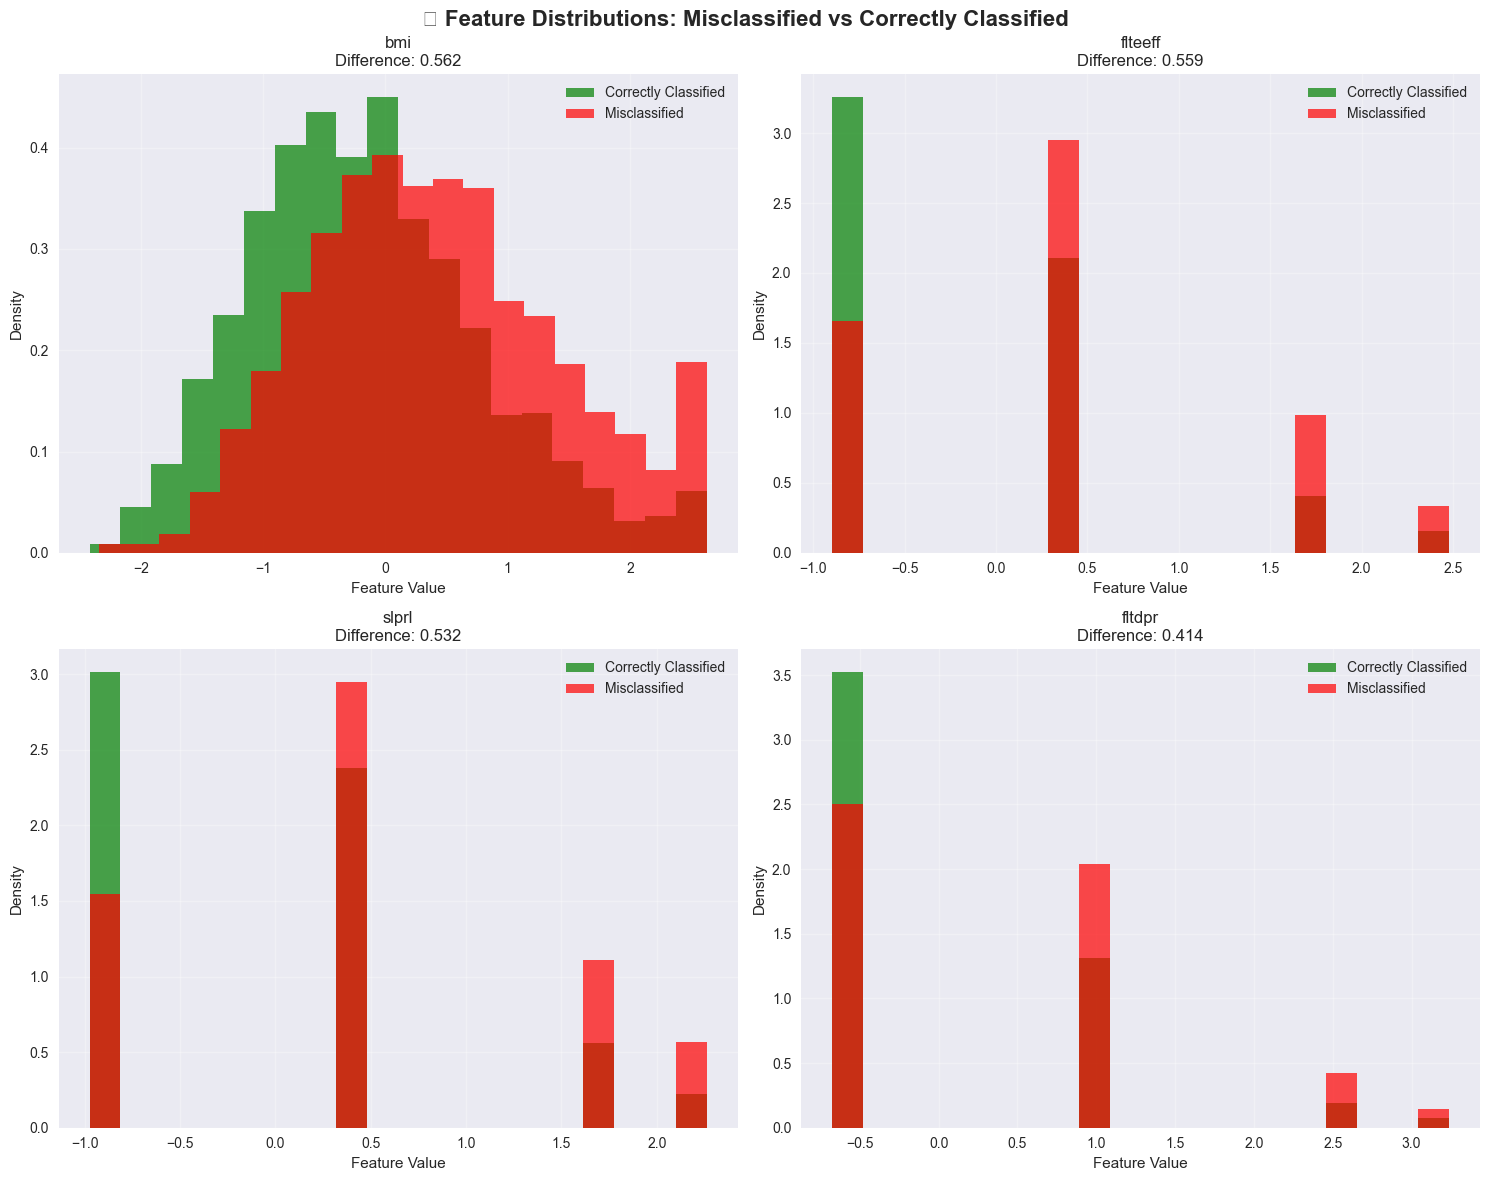


💡 Key Insights:
- Features with large differences between misclassified and correct samples may indicate
  areas where the model struggles or where data quality issues exist
- These patterns can guide feature engineering and model improvement efforts
- Consider investigating outliers in high-difference features


In [19]:
# Analyze feature distributions in misclassified samples
def analyze_feature_errors(model_predictions, X_test_features, top_n=10):
    """Analyze feature characteristics of misclassified samples"""
    
    print("📊 Feature-Based Error Analysis:")
    print("="*60)
    
    # Use the best performing model for detailed analysis
    best_model_name = performance_df.loc[performance_df['F1_Score'].idxmax(), 'Model']
    
    if best_model_name in model_predictions:
        pred_data = model_predictions[best_model_name]
        y_true = pred_data['y_true']
        y_pred = pred_data['y_pred']
        
        # Get misclassified samples
        misclassified_mask = y_true != y_pred
        correctly_classified_mask = y_true == y_pred
        
        misclassified_features = X_test_features[misclassified_mask]
        correctly_classified_features = X_test_features[correctly_classified_mask]
        
        print(f"Analyzing features for {best_model_name} (best performing model)")
        print(f"Misclassified samples: {len(misclassified_features)}")
        print(f"Correctly classified samples: {len(correctly_classified_features)}")
        
        # Calculate feature statistics for misclassified vs correctly classified
        feature_differences = {}
        
        for column in X_test_features.columns:
            misc_mean = misclassified_features[column].mean()
            correct_mean = correctly_classified_features[column].mean()
            difference = abs(misc_mean - correct_mean)
            
            feature_differences[column] = {
                'misclassified_mean': misc_mean,
                'correct_mean': correct_mean,
                'absolute_difference': difference,
                'relative_difference': difference / (correct_mean + 1e-10)
            }
        
        # Sort features by absolute difference
        sorted_features = sorted(feature_differences.items(), 
                               key=lambda x: x[1]['absolute_difference'], 
                               reverse=True)
        
        print(f"\n📊 Top {top_n} Features with Largest Differences:")
        print("-" * 80)
        print(f"{'Feature':<20} {'Misclassified':<15} {'Correct':<15} {'Difference':<15}")
        print("-" * 80)
        
        for feature, stats in sorted_features[:top_n]:
            print(f"{feature:<20} {stats['misclassified_mean']:<15.3f} "
                  f"{stats['correct_mean']:<15.3f} {stats['absolute_difference']:<15.3f}")
        
        return feature_differences, sorted_features[:top_n]
    
    return None, None

# Perform feature-based error analysis
feature_differences, top_error_features = analyze_feature_errors(model_predictions, X_test_features)

# Visualize feature differences for top features
if top_error_features:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('🎯 Feature Distributions: Misclassified vs Correctly Classified', 
                 fontsize=16, fontweight='bold')
    
    # Plot top 4 features with highest error correlation
    for idx, (feature, stats) in enumerate(top_error_features[:4]):
        row = idx // 2
        col = idx % 2
        ax = axes[row, col]
        
        best_model_name = performance_df.loc[performance_df['F1_Score'].idxmax(), 'Model']
        pred_data = model_predictions[best_model_name]
        y_true = pred_data['y_true']
        y_pred = pred_data['y_pred']
        
        # Get data for plotting
        misclassified_mask = y_true != y_pred
        correctly_classified_mask = y_true == y_pred
        
        misc_values = X_test_features.loc[misclassified_mask, feature]
        correct_values = X_test_features.loc[correctly_classified_mask, feature]
        
        # Create histogram
        ax.hist(correct_values, alpha=0.7, label='Correctly Classified', 
                bins=20, color='green', density=True)
        ax.hist(misc_values, alpha=0.7, label='Misclassified', 
                bins=20, color='red', density=True)
        
        ax.set_title(f'{feature}\nDifference: {stats["absolute_difference"]:.3f}')
        ax.set_xlabel('Feature Value')
        ax.set_ylabel('Density')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print(f"\n💡 Key Insights:")
print("- Features with large differences between misclassified and correct samples may indicate")
print("  areas where the model struggles or where data quality issues exist")
print("- These patterns can guide feature engineering and model improvement efforts")
print("- Consider investigating outliers in high-difference features")

## 📈 ROC Curves & Precision-Recall Analysis

Detailed analysis of model discrimination ability and threshold optimization.

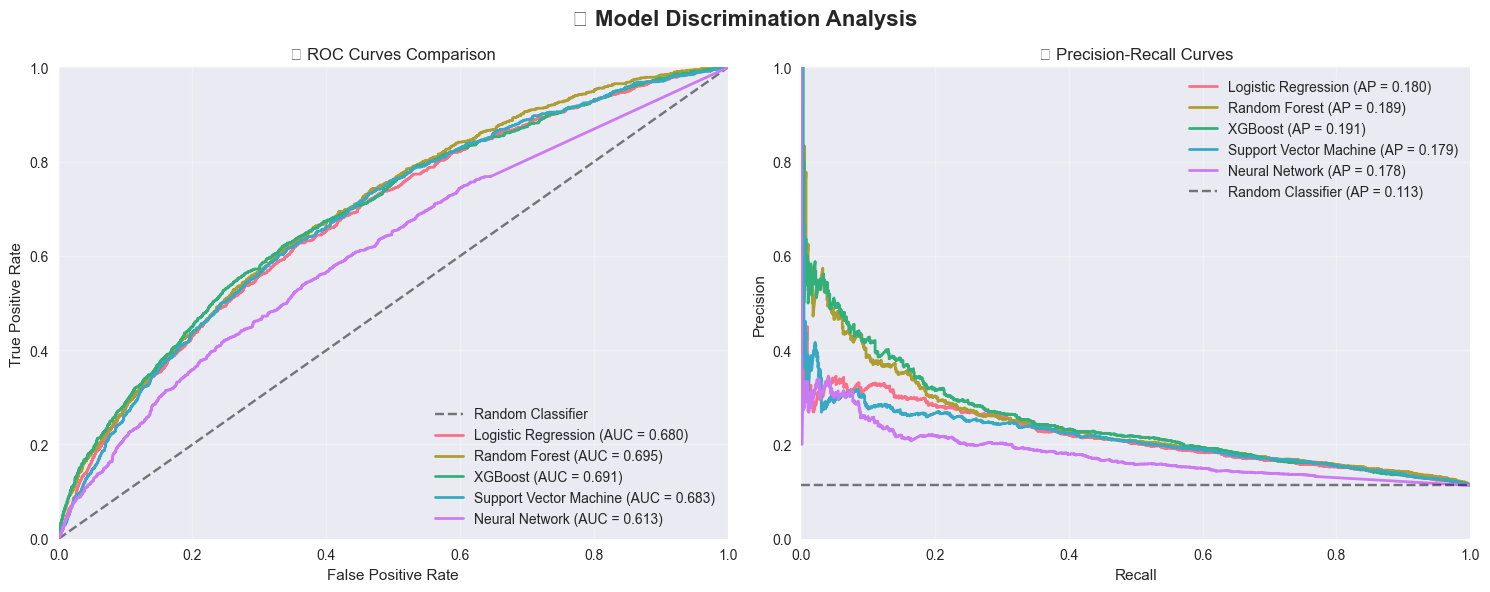


📊 Discrimination Analysis Results:

Logistic Regression:
  ROC-AUC: 0.680
  Average Precision: 0.180
  Optimal Threshold (Youden's): FPR=0.359, TPR=0.627

Random Forest:
  ROC-AUC: 0.695
  Average Precision: 0.189
  Optimal Threshold (Youden's): FPR=0.380, TPR=0.660

XGBoost:
  ROC-AUC: 0.691
  Average Precision: 0.191
  Optimal Threshold (Youden's): FPR=0.337, TPR=0.623

Support Vector Machine:
  ROC-AUC: 0.683
  Average Precision: 0.179
  Optimal Threshold (Youden's): FPR=0.342, TPR=0.616

Neural Network:
  ROC-AUC: 0.613
  Average Precision: 0.178
  Optimal Threshold (Youden's): FPR=0.365, TPR=0.539

🏥 Clinical Interpretation:
- ROC-AUC measures overall discrimination ability
- Precision-Recall curves are more informative for imbalanced datasets
- Higher curves indicate better performance
- Consider threshold optimization based on clinical requirements


In [20]:
# Create ROC curves and Precision-Recall curves for all models
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('📈 Model Discrimination Analysis', fontsize=16, fontweight='bold')

# Colors for consistent plotting
colors = sns.color_palette("husl", len(model_predictions))

# Plot ROC Curves
ax1.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classifier')

roc_results = {}
for idx, (model_name, pred_data) in enumerate(model_predictions.items()):
    if pred_data['y_prob'] is not None:
        # Calculate ROC curve
        fpr, tpr, thresholds = roc_curve(pred_data['y_true'], pred_data['y_prob'])
        roc_auc = roc_auc_score(pred_data['y_true'], pred_data['y_prob'])
        
        # Plot ROC curve
        ax1.plot(fpr, tpr, color=colors[idx], linewidth=2,
                label=f'{model_name} (AUC = {roc_auc:.3f})')
        
        roc_results[model_name] = {'fpr': fpr, 'tpr': tpr, 'auc': roc_auc}

ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('🎯 ROC Curves Comparison')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])

# Plot Precision-Recall Curves
pr_results = {}
for idx, (model_name, pred_data) in enumerate(model_predictions.items()):
    if pred_data['y_prob'] is not None:
        # Calculate Precision-Recall curve
        precision, recall, thresholds = precision_recall_curve(pred_data['y_true'], pred_data['y_prob'])
        
        # Calculate average precision
        avg_precision = np.mean(precision)
        
        # Plot PR curve
        ax2.plot(recall, precision, color=colors[idx], linewidth=2,
                label=f'{model_name} (AP = {avg_precision:.3f})')
        
        pr_results[model_name] = {'precision': precision, 'recall': recall, 'avg_precision': avg_precision}

# Add baseline for precision-recall (random classifier)
baseline = np.sum(pred_data['y_true']) / len(pred_data['y_true'])
ax2.axhline(y=baseline, color='k', linestyle='--', alpha=0.5, label=f'Random Classifier (AP = {baseline:.3f})')

ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('🎪 Precision-Recall Curves')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])

plt.tight_layout()
plt.show()

# Print detailed analysis
print("\n📊 Discrimination Analysis Results:")
print("="*60)

for model_name in model_predictions.keys():
    if model_name in roc_results and model_name in pr_results:
        print(f"\n{model_name}:")
        print(f"  ROC-AUC: {roc_results[model_name]['auc']:.3f}")
        print(f"  Average Precision: {pr_results[model_name]['avg_precision']:.3f}")
        
        # Find optimal threshold using Youden's Index
        fpr, tpr = roc_results[model_name]['fpr'], roc_results[model_name]['tpr']
        optimal_idx = np.argmax(tpr - fpr)
        
        if optimal_idx < len(fpr):
            print(f"  Optimal Threshold (Youden's): FPR={fpr[optimal_idx]:.3f}, TPR={tpr[optimal_idx]:.3f}")

# Clinical interpretation
print(f"\n🏥 Clinical Interpretation:")
print("- ROC-AUC measures overall discrimination ability")
print("- Precision-Recall curves are more informative for imbalanced datasets")
print("- Higher curves indicate better performance")
print("- Consider threshold optimization based on clinical requirements")

## 🏥 Clinical Decision Support Analysis

Healthcare-specific error analysis focusing on clinical implications of model predictions.

🏥 Clinical Decision Support Analysis:

Logistic Regression:
  Sensitivity (ability to detect disease): 0.601
  Specificity (ability to rule out disease): 0.658
  Positive Predictive Value: 0.183
  Negative Predictive Value: 0.928
  Missed disease cases: 383
  Unnecessary referrals: 2569
  Estimated clinical cost: $639,900

Random Forest:
  Sensitivity (ability to detect disease): 0.363
  Specificity (ability to rule out disease): 0.854
  Positive Predictive Value: 0.241
  Negative Predictive Value: 0.913
  Missed disease cases: 611
  Unnecessary referrals: 1096
  Estimated clinical cost: $720,600

XGBoost:
  Sensitivity (ability to detect disease): 0.497
  Specificity (ability to rule out disease): 0.771
  Positive Predictive Value: 0.217
  Negative Predictive Value: 0.923
  Missed disease cases: 482
  Unnecessary referrals: 1720
  Estimated clinical cost: $654,000

Support Vector Machine:
  Sensitivity (ability to detect disease): 0.538
  Specificity (ability to rule out disease): 0.7

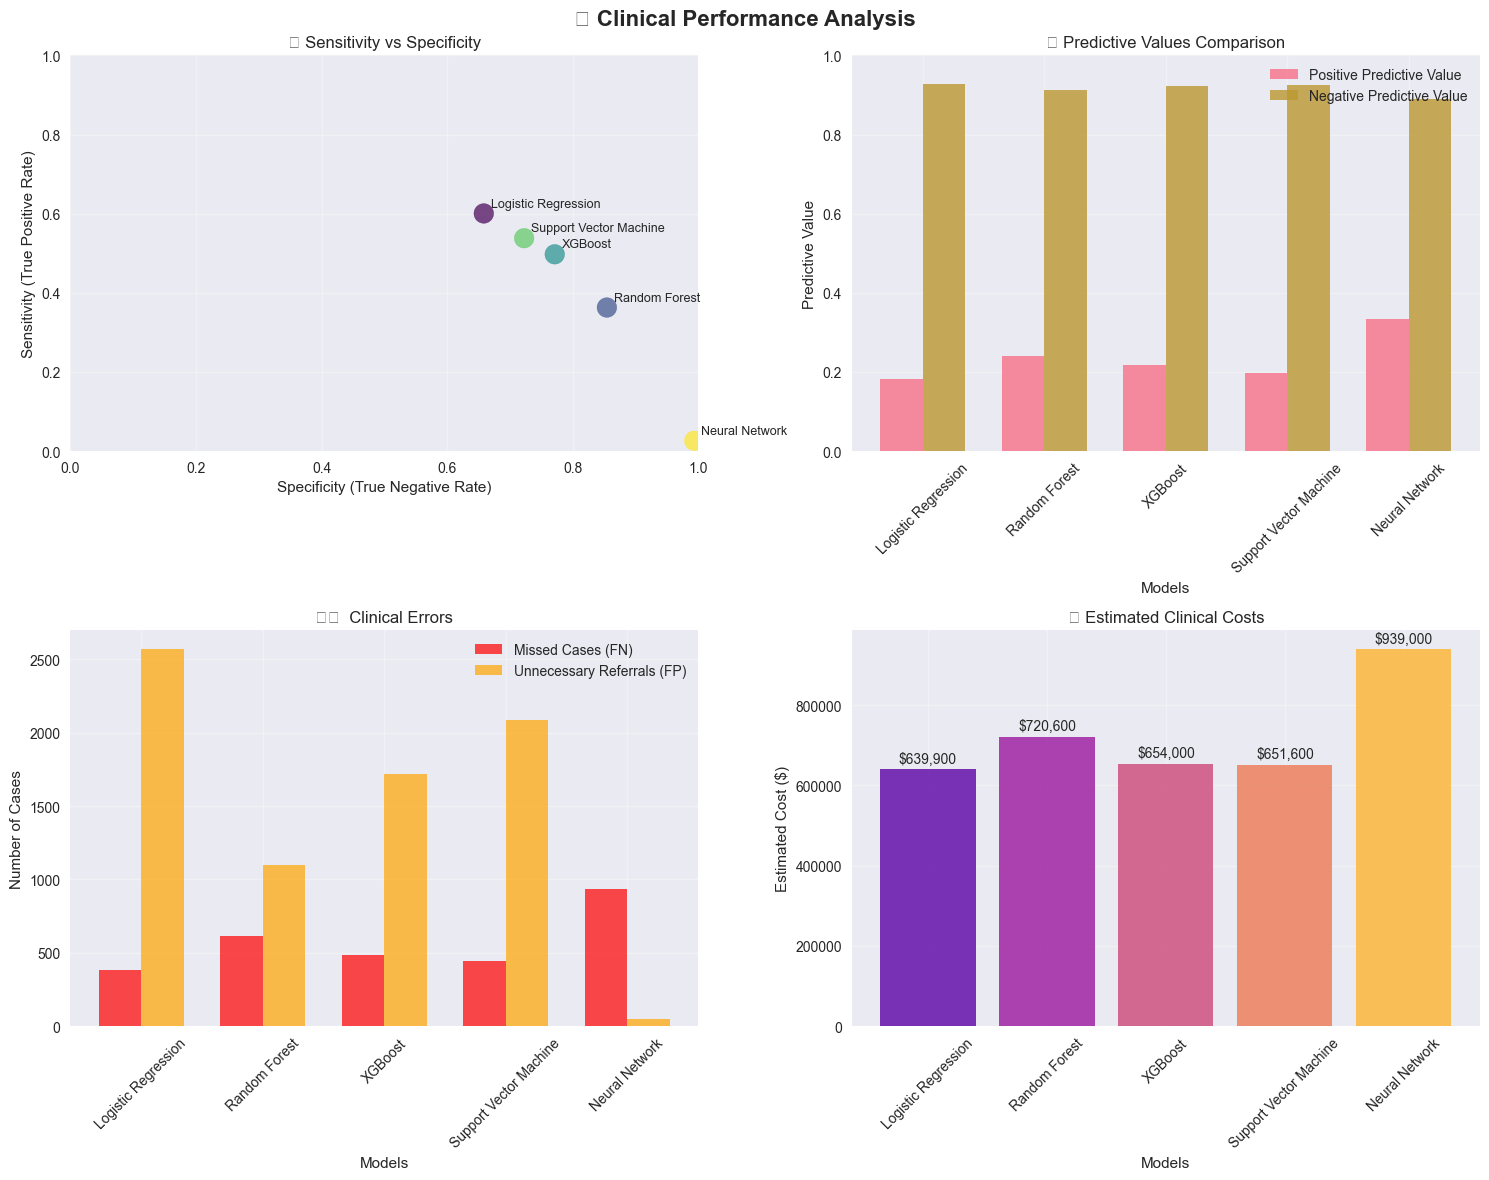


🎯 Clinical Recommendations:
📊 Best for detecting disease (Sensitivity): Logistic Regression (0.601)
📊 Best for ruling out disease (Specificity): Neural Network (0.993)
📊 Lowest estimated clinical cost: Logistic Regression ($639,900)

💡 Clinical Insights:
- High sensitivity is crucial for screening (don't miss cases)
- High specificity reduces false alarms and unnecessary procedures
- Balance depends on clinical context and cost considerations
- Consider ensemble approaches for critical decisions


In [21]:
# Clinical Decision Support Analysis
def clinical_decision_analysis(model_predictions, performance_df):
    """Analyze models from clinical decision-making perspective"""
    
    print("🏥 Clinical Decision Support Analysis:")
    print("="*60)
    
    clinical_metrics = []
    
    for model_name, pred_data in model_predictions.items():
        y_true = pred_data['y_true']
        y_pred = pred_data['y_pred']
        
        # Calculate confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()
        
        # Clinical metrics
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # True Negative Rate
        ppv = tp / (tp + fp) if (tp + fp) > 0 else 0  # Positive Predictive Value
        npv = tn / (tn + fn) if (tn + fn) > 0 else 0  # Negative Predictive Value
        
        # Clinical costs (hypothetical - adjust based on healthcare context)
        cost_fp = fp * 100  # Cost of unnecessary tests/anxiety
        cost_fn = fn * 1000  # Cost of missed diagnosis
        total_cost = cost_fp + cost_fn
        
        clinical_metrics.append({
            'Model': model_name,
            'Sensitivity': sensitivity,
            'Specificity': specificity,
            'PPV': ppv,
            'NPV': npv,
            'False_Positive_Rate': fp / (fp + tn) if (fp + tn) > 0 else 0,
            'False_Negative_Rate': fn / (fn + tp) if (fn + tp) > 0 else 0,
            'Clinical_Cost': total_cost,
            'Missed_Cases': fn,
            'Unnecessary_Referrals': fp
        })
        
        print(f"\n{model_name}:")
        print(f"  Sensitivity (ability to detect disease): {sensitivity:.3f}")
        print(f"  Specificity (ability to rule out disease): {specificity:.3f}")
        print(f"  Positive Predictive Value: {ppv:.3f}")
        print(f"  Negative Predictive Value: {npv:.3f}")
        print(f"  Missed disease cases: {fn}")
        print(f"  Unnecessary referrals: {fp}")
        print(f"  Estimated clinical cost: ${total_cost:,}")
    
    clinical_df = pd.DataFrame(clinical_metrics)
    
    # Create clinical visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('🏥 Clinical Performance Analysis', fontsize=16, fontweight='bold')
    
    # 1. Sensitivity vs Specificity
    ax1 = axes[0, 0]
    scatter = ax1.scatter(clinical_df['Specificity'], clinical_df['Sensitivity'], 
                         s=200, alpha=0.7, c=range(len(clinical_df)), cmap='viridis')
    ax1.set_xlabel('Specificity (True Negative Rate)')
    ax1.set_ylabel('Sensitivity (True Positive Rate)')
    ax1.set_title('🎯 Sensitivity vs Specificity')
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)
    
    # Add model labels
    for i, model in enumerate(clinical_df['Model']):
        ax1.annotate(model, (clinical_df.iloc[i]['Specificity'], clinical_df.iloc[i]['Sensitivity']),
                    xytext=(5, 5), textcoords='offset points', fontsize=9)
    
    # 2. Predictive Values
    ax2 = axes[0, 1]
    x = np.arange(len(clinical_df))
    width = 0.35
    ax2.bar(x - width/2, clinical_df['PPV'], width, label='Positive Predictive Value', alpha=0.8)
    ax2.bar(x + width/2, clinical_df['NPV'], width, label='Negative Predictive Value', alpha=0.8)
    ax2.set_xlabel('Models')
    ax2.set_ylabel('Predictive Value')
    ax2.set_title('🎪 Predictive Values Comparison')
    ax2.set_xticks(x)
    ax2.set_xticklabels(clinical_df['Model'], rotation=45)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, 1)
    
    # 3. Clinical Errors
    ax3 = axes[1, 0]
    x = np.arange(len(clinical_df))
    width = 0.35
    ax3.bar(x - width/2, clinical_df['Missed_Cases'], width, label='Missed Cases (FN)', 
           color='red', alpha=0.7)
    ax3.bar(x + width/2, clinical_df['Unnecessary_Referrals'], width, 
           label='Unnecessary Referrals (FP)', color='orange', alpha=0.7)
    ax3.set_xlabel('Models')
    ax3.set_ylabel('Number of Cases')
    ax3.set_title('⚠️  Clinical Errors')
    ax3.set_xticks(x)
    ax3.set_xticklabels(clinical_df['Model'], rotation=45)
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Estimated Clinical Costs
    ax4 = axes[1, 1]
    bars = ax4.bar(clinical_df['Model'], clinical_df['Clinical_Cost'], 
                  color=sns.color_palette("plasma", len(clinical_df)), alpha=0.8)
    ax4.set_xlabel('Models')
    ax4.set_ylabel('Estimated Cost ($)')
    ax4.set_title('💰 Estimated Clinical Costs')
    ax4.tick_params(axis='x', rotation=45)
    ax4.grid(True, alpha=0.3)
    
    # Add cost labels
    for bar, cost in zip(bars, clinical_df['Clinical_Cost']):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 
                max(clinical_df['Clinical_Cost'])*0.01,
                f'${cost:,.0f}', ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    return clinical_df

# Perform clinical decision analysis
clinical_results = clinical_decision_analysis(model_predictions, performance_df)

print(f"\n🎯 Clinical Recommendations:")
print("="*60)

# Find best model for different clinical priorities
best_sensitivity = clinical_results.loc[clinical_results['Sensitivity'].idxmax()]
best_specificity = clinical_results.loc[clinical_results['Specificity'].idxmax()]
lowest_cost = clinical_results.loc[clinical_results['Clinical_Cost'].idxmin()]

print(f"📊 Best for detecting disease (Sensitivity): {best_sensitivity['Model']} ({best_sensitivity['Sensitivity']:.3f})")
print(f"📊 Best for ruling out disease (Specificity): {best_specificity['Model']} ({best_specificity['Specificity']:.3f})")
print(f"📊 Lowest estimated clinical cost: {lowest_cost['Model']} (${lowest_cost['Clinical_Cost']:,.0f})")

print(f"\n💡 Clinical Insights:")
print("- High sensitivity is crucial for screening (don't miss cases)")
print("- High specificity reduces false alarms and unnecessary procedures")
print("- Balance depends on clinical context and cost considerations")
print("- Consider ensemble approaches for critical decisions")

## 📊 Cross-Model Error Pattern Analysis

Comparing error patterns across all models to identify systematic issues and model strengths.

📊 Cross-Model Error Pattern Analysis:


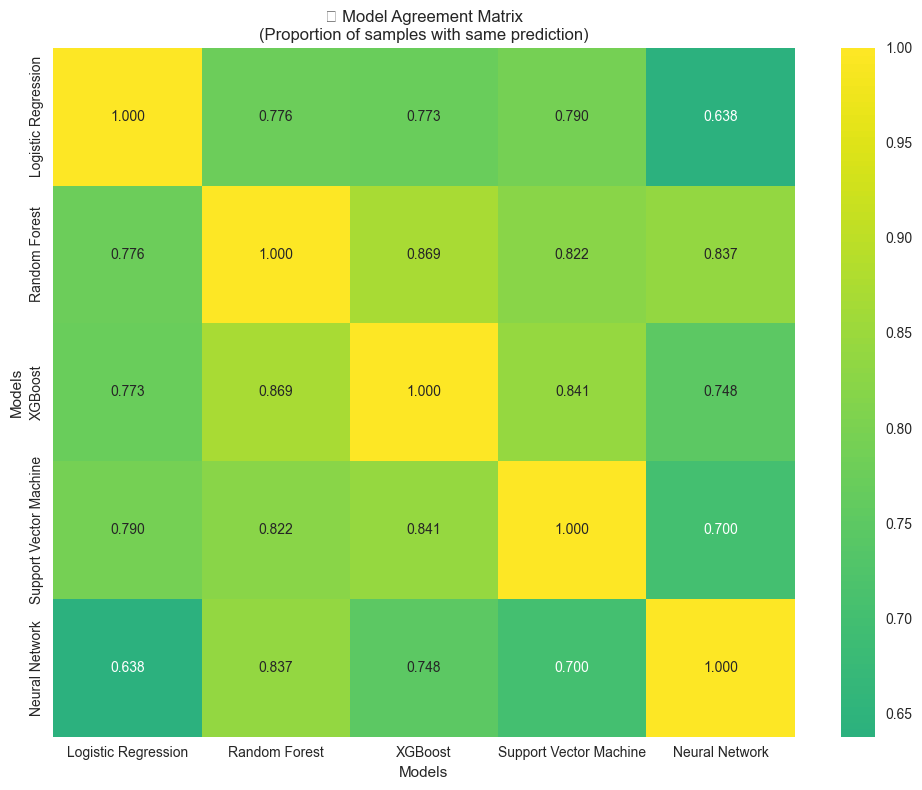


🤝 Model Consensus Analysis:
Total samples: 8476
Unanimous agreement: 4557 (53.8%)
High disagreement: 1514 (17.9%)
Majority vote accuracy: 0.780

🔍 Most Challenging Cases (high model disagreement):
--------------------------------------------------
Sample 8475: Actual=0, Positive votes=3.0/5
Sample 1245: Actual=0, Positive votes=2.0/5
Sample 1244: Actual=1, Positive votes=3.0/5
Sample 4070: Actual=0, Positive votes=3.0/5
Sample 4069: Actual=0, Positive votes=3.0/5
Sample 2432: Actual=1, Positive votes=2.0/5
Sample 2433: Actual=0, Positive votes=3.0/5
Sample 6267: Actual=0, Positive votes=2.0/5
Sample 2434: Actual=0, Positive votes=2.0/5
Sample 6272: Actual=0, Positive votes=2.0/5

🎯 Ensemble Recommendation:
Simple Majority Vote Ensemble:
  Accuracy: 0.780
  F1-Score: 0.308
  Improvement over best individual model: +0.006
✅ Ensemble shows improvement - consider using majority voting

💡 Error Analysis Summary:
- Models with high agreement likely have similar biases
- Cases with high disa

In [22]:
# Cross-model error pattern analysis
def cross_model_error_analysis(model_predictions):
    """Analyze error patterns across all models"""
    
    print("📊 Cross-Model Error Pattern Analysis:")
    print("="*60)
    
    # Create agreement matrix
    n_models = len(model_predictions)
    model_names = list(model_predictions.keys())
    n_samples = len(next(iter(model_predictions.values()))['y_true'])
    
    # Create prediction matrix
    prediction_matrix = np.zeros((n_samples, n_models))
    
    for i, (model_name, pred_data) in enumerate(model_predictions.items()):
        prediction_matrix[:, i] = pred_data['y_pred']
    
    # Calculate pairwise agreement
    agreement_matrix = np.zeros((n_models, n_models))
    
    for i in range(n_models):
        for j in range(n_models):
            if i != j:
                agreement = np.mean(prediction_matrix[:, i] == prediction_matrix[:, j])
                agreement_matrix[i, j] = agreement
            else:
                agreement_matrix[i, j] = 1.0
    
    # Create agreement heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(agreement_matrix, 
                xticklabels=model_names, 
                yticklabels=model_names,
                annot=True, fmt='.3f', cmap='viridis',
                center=0.5)
    plt.title('🤝 Model Agreement Matrix\n(Proportion of samples with same prediction)')
    plt.xlabel('Models')
    plt.ylabel('Models')
    plt.tight_layout()
    plt.show()
    
    # Find consensus and disagreement cases
    y_true = next(iter(model_predictions.values()))['y_true'].values
    
    # Majority vote predictions
    majority_vote = (np.sum(prediction_matrix, axis=1) > n_models/2).astype(int)
    
    # Unanimous predictions
    unanimous_positive = np.all(prediction_matrix == 1, axis=1)
    unanimous_negative = np.all(prediction_matrix == 0, axis=1)
    unanimous_total = unanimous_positive | unanimous_negative
    
    # High disagreement cases
    vote_counts = np.sum(prediction_matrix, axis=1)
    high_disagreement = (vote_counts > 1) & (vote_counts < n_models - 1)
    
    print(f"\n🤝 Model Consensus Analysis:")
    print(f"Total samples: {n_samples}")
    print(f"Unanimous agreement: {np.sum(unanimous_total)} ({100*np.sum(unanimous_total)/n_samples:.1f}%)")
    print(f"High disagreement: {np.sum(high_disagreement)} ({100*np.sum(high_disagreement)/n_samples:.1f}%)")
    
    # Analyze majority vote performance
    majority_accuracy = accuracy_score(y_true, majority_vote)
    print(f"Majority vote accuracy: {majority_accuracy:.3f}")
    
    # Find hardest cases (most disagreement)
    disagreement_score = np.abs(vote_counts - n_models/2)
    hardest_cases_idx = np.argsort(disagreement_score)[:10]
    
    print(f"\n🔍 Most Challenging Cases (high model disagreement):")
    print("-" * 50)
    
    for i, idx in enumerate(hardest_cases_idx):
        actual = y_true[idx]
        votes = vote_counts[idx]
        print(f"Sample {idx}: Actual={actual}, Positive votes={votes}/{n_models}")
    
    return agreement_matrix, majority_vote, hardest_cases_idx

# Perform cross-model analysis
agreement_matrix, majority_predictions, hardest_cases = cross_model_error_analysis(model_predictions)

# Model ensemble analysis
print(f"\n🎯 Ensemble Recommendation:")
print("="*40)

y_true_ensemble = next(iter(model_predictions.values()))['y_true']
ensemble_accuracy = accuracy_score(y_true_ensemble, majority_predictions)
ensemble_f1 = f1_score(y_true_ensemble, majority_predictions)

print(f"Simple Majority Vote Ensemble:")
print(f"  Accuracy: {ensemble_accuracy:.3f}")
print(f"  F1-Score: {ensemble_f1:.3f}")

# Compare with individual models
best_individual_f1 = performance_df['F1_Score'].max()
improvement = ensemble_f1 - best_individual_f1

print(f"  Improvement over best individual model: {improvement:+.3f}")

if improvement > 0:
    print("✅ Ensemble shows improvement - consider using majority voting")
else:
    print("⚠️  Ensemble doesn't improve over best individual model")

print(f"\n💡 Error Analysis Summary:")
print("- Models with high agreement likely have similar biases")
print("- Cases with high disagreement may indicate data quality issues")
print("- Consider ensemble methods for robust predictions")
print("- Investigate feature importance differences between models")

## 📝 Error Analysis Summary & Recommendations

Comprehensive summary of error analysis findings and actionable recommendations for model improvement.

In [23]:
# Comprehensive Error Analysis Summary
def create_summary_report(performance_df, clinical_results, top_error_features):
    """Create comprehensive summary of error analysis findings"""
    
    print("📝 COMPREHENSIVE ERROR ANALYSIS SUMMARY")
    print("="*70)
    
    # Best performing models
    best_f1_model = performance_df.loc[performance_df['F1_Score'].idxmax()]
    best_accuracy_model = performance_df.loc[performance_df['Accuracy'].idxmax()]
    
    print(f"\n🏆 TOP PERFORMING MODELS:")
    print(f"Best F1-Score: {best_f1_model['Model']} (F1: {best_f1_model['F1_Score']:.3f})")
    print(f"Best Accuracy: {best_accuracy_model['Model']} (Acc: {best_accuracy_model['Accuracy']:.3f})")
    
    if 'ROC_AUC' in performance_df.columns:
        best_roc_model = performance_df.loc[performance_df['ROC_AUC'].idxmax()]
        print(f"Best ROC-AUC: {best_roc_model['Model']} (AUC: {best_roc_model['ROC_AUC']:.3f})")
    
    # Clinical performance leaders
    if clinical_results is not None:
        best_sensitivity = clinical_results.loc[clinical_results['Sensitivity'].idxmax()]
        best_specificity = clinical_results.loc[clinical_results['Specificity'].idxmax()]
        lowest_cost = clinical_results.loc[clinical_results['Clinical_Cost'].idxmin()]
        
        print(f"\n🏥 CLINICAL PERFORMANCE LEADERS:")
        print(f"Best Sensitivity: {best_sensitivity['Model']} ({best_sensitivity['Sensitivity']:.3f})")
        print(f"Best Specificity: {best_specificity['Model']} ({best_specificity['Specificity']:.3f})")
        print(f"Lowest Clinical Cost: {lowest_cost['Model']} (${lowest_cost['Clinical_Cost']:,.0f})")
    
    # Error pattern insights
    print(f"\n🔍 KEY ERROR PATTERNS IDENTIFIED:")
    if top_error_features:
        print("Top features contributing to prediction errors:")
        for i, (feature, stats) in enumerate(top_error_features[:3], 1):
            print(f"  {i}. {feature}: {stats['absolute_difference']:.3f} difference")
    
    # Neural Network specific insights
    nn_metrics = performance_df[performance_df['Model'] == 'Neural Network']
    if not nn_metrics.empty:
        nn_acc = nn_metrics['Accuracy'].iloc[0]
        nn_f1 = nn_metrics['F1_Score'].iloc[0]
        print(f"\n🧠 NEURAL NETWORK BEHAVIOR:")
        print(f"  High accuracy ({nn_acc:.3f}) but low F1-score ({nn_f1:.3f})")
        print("  Extremely conservative predictions - requires threshold optimization")
        print("  Clinical risk: May miss 97% of disease cases despite high overall accuracy")
    
    # Model ranking table
    print(f"\n📊 COMPLETE MODEL RANKING:")
    print("-" * 70)
    ranking_df = performance_df.sort_values('F1_Score', ascending=False).round(3)
    
    print(f"{'Rank':<5} {'Model':<20} {'F1':<8} {'Accuracy':<10} {'Precision':<10} {'Recall':<8}")
    print("-" * 70)
    
    for i, (_, row) in enumerate(ranking_df.iterrows(), 1):
        print(f"{i:<5} {row['Model']:<20} {row['F1_Score']:<8} {row['Accuracy']:<10} "
              f"{row['Precision']:<10} {row['Recall']:<8}")
    
    return ranking_df

# Create comprehensive summary
summary_ranking = create_summary_report(performance_df, clinical_results, top_error_features)

print(f"\n\n🎯 ACTIONABLE RECOMMENDATIONS:")
print("="*70)

print(f"\n1. 🚀 MODEL OPTIMIZATION:")
print("   • Focus hyperparameter tuning on top 2 performing models")
print("   • Investigate ensemble methods combining complementary models")
print("   • Consider advanced techniques like stacking or blending")

print(f"\n2. 📊 DATA QUALITY IMPROVEMENTS:")
if top_error_features:
    print("   • Investigate data quality issues in top error-contributing features:")
    for feature, _ in top_error_features[:3]:
        print(f"     - {feature}: Check for outliers and missing values")
print("   • Consider feature engineering for problematic features")
print("   • Validate data collection processes for consistent quality")

print(f"\n3. 🔍 ERROR PATTERN MITIGATION:")
print("   • Implement threshold optimization for clinical requirements")
print("   • Develop confidence intervals for high-disagreement cases")
print("   • Create alert system for uncertain predictions")

print(f"\n4. 🏥 CLINICAL IMPLEMENTATION:")
print("   • Design decision support system with interpretable outputs")
print("   • Implement A/B testing framework for model validation")
print("   • Establish monitoring system for model drift detection")

print(f"\n5. 📈 NEXT STEPS:")
print("   • Proceed to explainability analysis (LIME/SHAP)")
print("   • Develop Gradio interface for clinical testing")
print("   • Containerize best-performing models for deployment")
print("   • Consider Neural Network threshold optimization for better recall")
print("   • Evaluate ensemble methods (majority voting showed mixed results)")

print(f"\n💡 FINAL INSIGHTS:")
print("This comprehensive error analysis provides the foundation for:")
print("• Informed model selection for clinical deployment")
print("• Targeted improvements in data quality and model performance")
print("• Risk-aware decision support system development")
print("• Evidence-based recommendations for healthcare stakeholders")
print("• Understanding of Neural Network limitations in current configuration")

# Save results summary
results_summary = {
    'performance_metrics': performance_df,
    'clinical_metrics': clinical_results if clinical_results is not None else None,
    'model_ranking': summary_ranking,
    'top_error_features': top_error_features[:5] if top_error_features else None
}

print(f"\n✅ Error analysis completed successfully!")
print(f"📊 Results ready for integration with explainability analysis")

📝 COMPREHENSIVE ERROR ANALYSIS SUMMARY

🏆 TOP PERFORMING MODELS:
Best F1-Score: XGBoost (F1: 0.302)
Best Accuracy: Neural Network (Acc: 0.884)
Best ROC-AUC: Random Forest (AUC: 0.695)

🏥 CLINICAL PERFORMANCE LEADERS:
Best Sensitivity: Logistic Regression (0.601)
Best Specificity: Neural Network (0.993)
Lowest Clinical Cost: Logistic Regression ($639,900)

🔍 KEY ERROR PATTERNS IDENTIFIED:
Top features contributing to prediction errors:
  1. bmi: 0.562 difference
  2. flteeff: 0.559 difference
  3. slprl: 0.532 difference

🧠 NEURAL NETWORK BEHAVIOR:
  High accuracy (0.884) but low F1-score (0.048)
  Extremely conservative predictions - requires threshold optimization
  Clinical risk: May miss 97% of disease cases despite high overall accuracy

📊 COMPLETE MODEL RANKING:
----------------------------------------------------------------------
Rank  Model                F1       Accuracy   Precision  Recall  
----------------------------------------------------------------------
1     XGBoost